# Bitmap Graphics

In [1]:
# Settings and imports.
%matplotlib inline
from collections import Counter, OrderedDict, defaultdict
from functools import partial
from itertools import count
from math import sqrt, pi, sin, cos, atan, radians, degrees
from random import random
from time import time
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageColor
import seaborn as sns

#sns.set()
#sns.set_context('paper', font_scale=2.0)

-----

# A) Basic Shapes



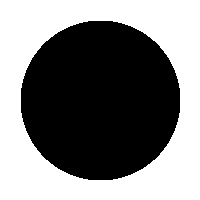

In [2]:
BLACK = (0, 0, 0)

def disc(r, size):
    im = Image.new('RGB', (size, size), color='white')
    mid = size / 2
    for x in range(size):
        for y in range(size):
            if (x-mid)**2 + (y-mid)**2 < r**2:
                im.putpixel((x, y), BLACK)
    return im

disc(r=80, size=200)

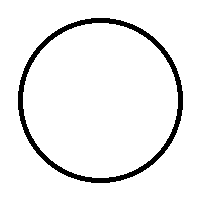

In [3]:
def circle(r, linewidth, size):
    mid = size / 2    
    def on_circle(x, y):
        return (
            (x-mid)**2 + (y-mid)**2 < (r+linewidth/2)**2
            and (x-mid)**2 + (y-mid)**2 > (r-linewidth/2)**2)

    im = Image.new('RGB', (size, size), color='white')
    for x in range(size):
        for y in range(size):
            if on_circle(x, y):
                im.putpixel((x, y), BLACK)
    return im

circle(r=80, linewidth=5, size=200)

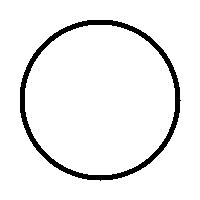

In [4]:
# In this function, I used different semantics of radius+linewidth
# - r is the outer radius.

def circle_parametric(r, linewidth, size):
    mid = size / 2 
    im = Image.new('RGB', (size, size), color='white')
    n_steps = 3 * 360  # TODO: Choose wrt. to r?
    for step in range(n_steps):
        alpha = 2 * pi * step / n_steps
        for radius in range(r - linewidth + 1, r+1):
            x = int(mid + radius * cos(alpha))
            y = int(mid + radius * sin(alpha))
            im.putpixel((x, y), BLACK)
    return im

circle_parametric(r=80, linewidth=5, size=200)

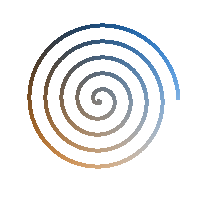

In [10]:
def get_color(x, y, size):
    blue = int(x/size * 255)
    red = int(y/size * 255)
    green = int((x+y)/(2*size) * 255)
    return (red, green, blue)

def spiral(r, linewidth, n_turns, size):
    mid = size / 2 
    im = Image.new('RGB', (size, size), color='white')
    n_steps_per_turn = 3 * 360
    n_steps_total = n_steps_per_turn * n_turns
    for step in range(n_steps_total):
        alpha = 2 * pi * step / n_steps_per_turn
        spiral_radius = r * step / n_steps_total
        for k in range(linewidth):
            x = int(mid + (spiral_radius-k) * cos(alpha))
            y = int(mid + (spiral_radius-k) * sin(alpha))
            im.putpixel((x, y), get_color(x, y, size))
    return im

spiral(r=80, linewidth=4, n_turns=5, size=200)

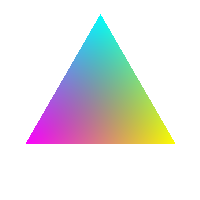

In [21]:
# Main trap: "image coordinates" - (0, 0) in top-left corner.
# TODO: Fix vertical shift (check for side=200).

def distance(a, b):
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    return sqrt(dx**2 + dy**2)


def triangle(side, size):
    def transform(ix, iy):
        """Convert image-coordinates into drawing coordinates,
           s.t. origin is at the center of bottom side.
        """
        mid = size / 2
        x = ix - mid
        y = size - iy - mid + (1/3) * side * sqrt(3)/2
        return x, y
    
    def in_triangle(x, y):
        # Assume transformed coordinates.
        in_halfplane1 = y <= -sqrt(3)*x + side*sqrt(3)/2
        in_halfplane2 = y <= sqrt(3)*x + side*sqrt(3)/2
        in_halfplane3 = y >= 0
        return in_halfplane1 and in_halfplane2 and in_halfplane3
    
    def get_color(x, y):
        vertices = [
            (0, side*sqrt(3)/2),
            (-side/2, 0),
            (side/2, 0)
        ]
        color = tuple(
            int(distance((x, y), vertex)/side * 255)
            for vertex in vertices)
        return color
    
    im = Image.new('RGB', (size, size), color='white')
    for ix in range(size):
        for iy in range(size):
            x, y = transform(ix, iy) 
            if in_triangle(x, y):
                im.putpixel((ix, iy), get_color(x, y))
    return im

triangle(side=150, size=200)

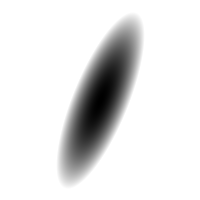

In [82]:
# TODO: Fix - I'm not able to rotate the ellipse arbitrarily.

def ellipse(a, b, c, size):
    mid = size / 2     
    im = Image.new('RGB', (size, size), color='white')
    for ix in range(size):
        for iy in range(size):
            x = ix - mid
            y = iy - mid
            dist = (x/a)**2 + (y/b)**2 + (x*y/(c**2))
            if dist <= 1:
                intensity = int(255 * dist)
                color = (intensity, intensity, intensity)
                im.putpixel((ix, iy), color)
    return im

ellipse(a=30, b=60, c=35, size=200)

-----

# B) Polygon

Implemented according to the advice from the lecture:
for each horizontal line:
color points based on even/odd number of intersections of
half-line with line segments of the polygon.

20 [10.588235294117647, 180.0, 180.0]


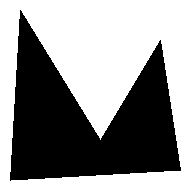

In [105]:
def get_x_intersection(segment, y):
    # Return x-coordiante of point on given y-coordinate,
    # that is on given segment (or None).
    ((x1, y1), (x2, y2)) = segment
    # Segment can be described parametrically as
    # [x1, y1] + t * [x2-x1, y2-y1].
    # So we just need to solve the following equations:
    # [x1, y1] + t * [x2-x1, y2-y1] = [x, y]
    # (with unknowns t in [0, 1] and x).
    t = (y - y1) / (y2 - y1)
    if t < 0 or t > 1:
        # The segment doesn't intersect given y-line.
        return None
    x = x1 + t * (x2 - x1)
    return x
    

def polygon(path):
    size = max(max(vertex) for vertex in path) + 10
    im = Image.new('RGB', (size, size), color='white')
    n = len(path)
    segments = [(path[k], path[(k+1)%n]) for k in range(n)]
    for y in range(size):
        intersections = [
            get_x_intersection(segment, y)
            for segment in segments]
        intersections = [x for x in intersections if x is not None]
        intersections = sorted(intersections)
        if len(intersections) % 2 != 0:
            print(y, intersections)
        for i in range(0, len(intersections), 2):
            if i+1 >= len(intersections):
                break
            start = round(intersections[i])
            end = round(intersections[i+1])
            for x in range(start, end+1):            
                im.putpixel((x, size-y), BLACK)
    return im


path = [(10, 10), (180, 20), (160, 150), (100, 50), (20, 180)]
polygon(path)

-----

# C) Effects